In [1]:
import os
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
import tensorflow as tf


In [2]:
# Test mode is set to false to avoid unwated testing outputs from the cells
test = False

In [3]:
YES_DIR_PATH = 'C:/Users/AbdullahAll.Mamun/project/Brain-Tumor-Detection/data/brain_tumor_dataset/yes/'
NO_DIR_PATH ='C:/Users/AbdullahAll.Mamun/project/Brain-Tumor-Detection/data/brain_tumor_dataset/no/'
# YES_DIR_PATH = 'brain_tumor_dataset/yes/'
# NO_DIR_PATH = 'brain_tumor_dataset/no/'
yes_imgs_name = os.listdir(YES_DIR_PATH)
no_imgs_name = os.listdir(NO_DIR_PATH)


In [4]:
def crop_image(img):
    # Resize the image to 256x256 pixels
    resized_img = cv2.resize(
        img,
        dsize=(256, 256),
        interpolation=cv2.INTER_CUBIC
    )
    # Convert the image to grayscale
    gray = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)

    # Apply a Gaussian blur to the image
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image by Binary Thresholding
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    
    # perform a series of erosions & dilations to remove any small regions of noise
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop
    ADD_PIXELS = 0
    cropped_img = resized_img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS,
                              extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return cropped_img

In [5]:
# Use crop_image function to crop the images
yes_imgs_cropped = [crop_image(cv2.imread(YES_DIR_PATH + img_file)) for img_file in yes_imgs_name]
no_imgs_cropped = [crop_image(cv2.imread(NO_DIR_PATH + img_file)) for img_file in no_imgs_name]

In [6]:
orig_imgs = yes_imgs_cropped + no_imgs_cropped
resized_imgs = [cv2.resize(img, dsize=(32, 32), interpolation=cv2.INTER_CUBIC) for img in orig_imgs]

In [7]:
X = np.squeeze(resized_imgs)

In [8]:
if (test):
    print(type(X))
    print(X.shape)
    print(X)
    print(resized_imgs)


In [9]:
# normalize data
X = X.astype('float32')
X /= 255

if (test):
    print(X)

In [10]:
labels_yes = np.full(len(yes_imgs_name), 1)
labels_no = np.full(len(no_imgs_name), 0)

img_labels = np.concatenate([labels_yes, labels_no])

In [11]:
if (test):
    print(img_labels.size, img_labels)

In [13]:
# Splitting the dataset into the Training set (i.e `x_train`) and Testing set/Validation set (i.e `x_valid`)
# We will also keep the original images of the validation set in `x_orig_valid` for visualization purposes
yes_imgs      = X[:155]
no_imgs       = X[155:]
yes_orig_imgs = orig_imgs[:155]
no_orig_imgs  = orig_imgs[155:]

x_yes_train   = yes_imgs[:124]
x_yes_valid   = yes_imgs[124:]
x_yes_orig_valid = yes_orig_imgs[124:]

x_no_train = no_imgs[:78]
x_no_valid = no_imgs[78:]
x_no_orig_valid = no_orig_imgs[78:]

x_train = np.concatenate([x_yes_train, x_no_train])
x_valid = np.concatenate([x_yes_valid, x_no_valid])
#x_orig_valid = np.concatenate([x_yes_orig_valid, x_no_orig_valid])

# Splitting the dataset labels for the Training set (i.e `y_train`) and Testing set/Validation set (i.e `y_valid`)
yes_labels = img_labels[:155]
no_labels = img_labels[155:]

y_yes_train = yes_labels[:124]
y_yes_valid = yes_labels[124:]

y_no_train = no_labels[:78]
y_no_valid = no_labels[78:]

y_train = np.concatenate([y_yes_train, y_no_train])
y_valid = np.concatenate([y_yes_valid, y_no_valid])

In [14]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=9,
          padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.45))

model.add(tf.keras.layers.Conv2D(
    filters=16, kernel_size=9, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(
    filters=36, kernel_size=9, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.15))


model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# model summary
# model.summary() # Uncomment to see the model summary. Model summary is already been shown the cell below in SVG representation

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc'])

In [22]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=200,
          validation_data=(x_valid, y_valid),)

# Saving the trained model
model.save('brain_tumor_detection_model.h5')

Epoch 1/200
2/2 [==============================] - 2s 449ms/step - loss: 0.7105 - acc: 0.4752 - val_loss: 0.6770 - val_acc: 0.6078
Epoch 2/200
2/2 [==============================] - 0s 224ms/step - loss: 0.6650 - acc: 0.6139 - val_loss: 0.6796 - val_acc: 0.6078
Epoch 3/200
2/2 [==============================] - 1s 267ms/step - loss: 0.6574 - acc: 0.6139 - val_loss: 0.6681 - val_acc: 0.6078
Epoch 4/200
2/2 [==============================] - 1s 241ms/step - loss: 0.6648 - acc: 0.6139 - val_loss: 0.6686 - val_acc: 0.6078
Epoch 5/200
2/2 [==============================] - 1s 221ms/step - loss: 0.6590 - acc: 0.6139 - val_loss: 0.6760 - val_acc: 0.6078
Epoch 6/200
2/2 [==============================] - 1s 229ms/step - loss: 0.6582 - acc: 0.6139 - val_loss: 0.6780 - val_acc: 0.6078
Epoch 7/200
2/2 [==============================] - 0s 235ms/step - loss: 0.6548 - acc: 0.6139 - val_loss: 0.6748 - val_acc: 0.6078
Epoch 8/200
2/2 [==============================] - 1s 235ms/step - loss: 0.6532 - a

2/2 [==============================] - 0s 9ms/step


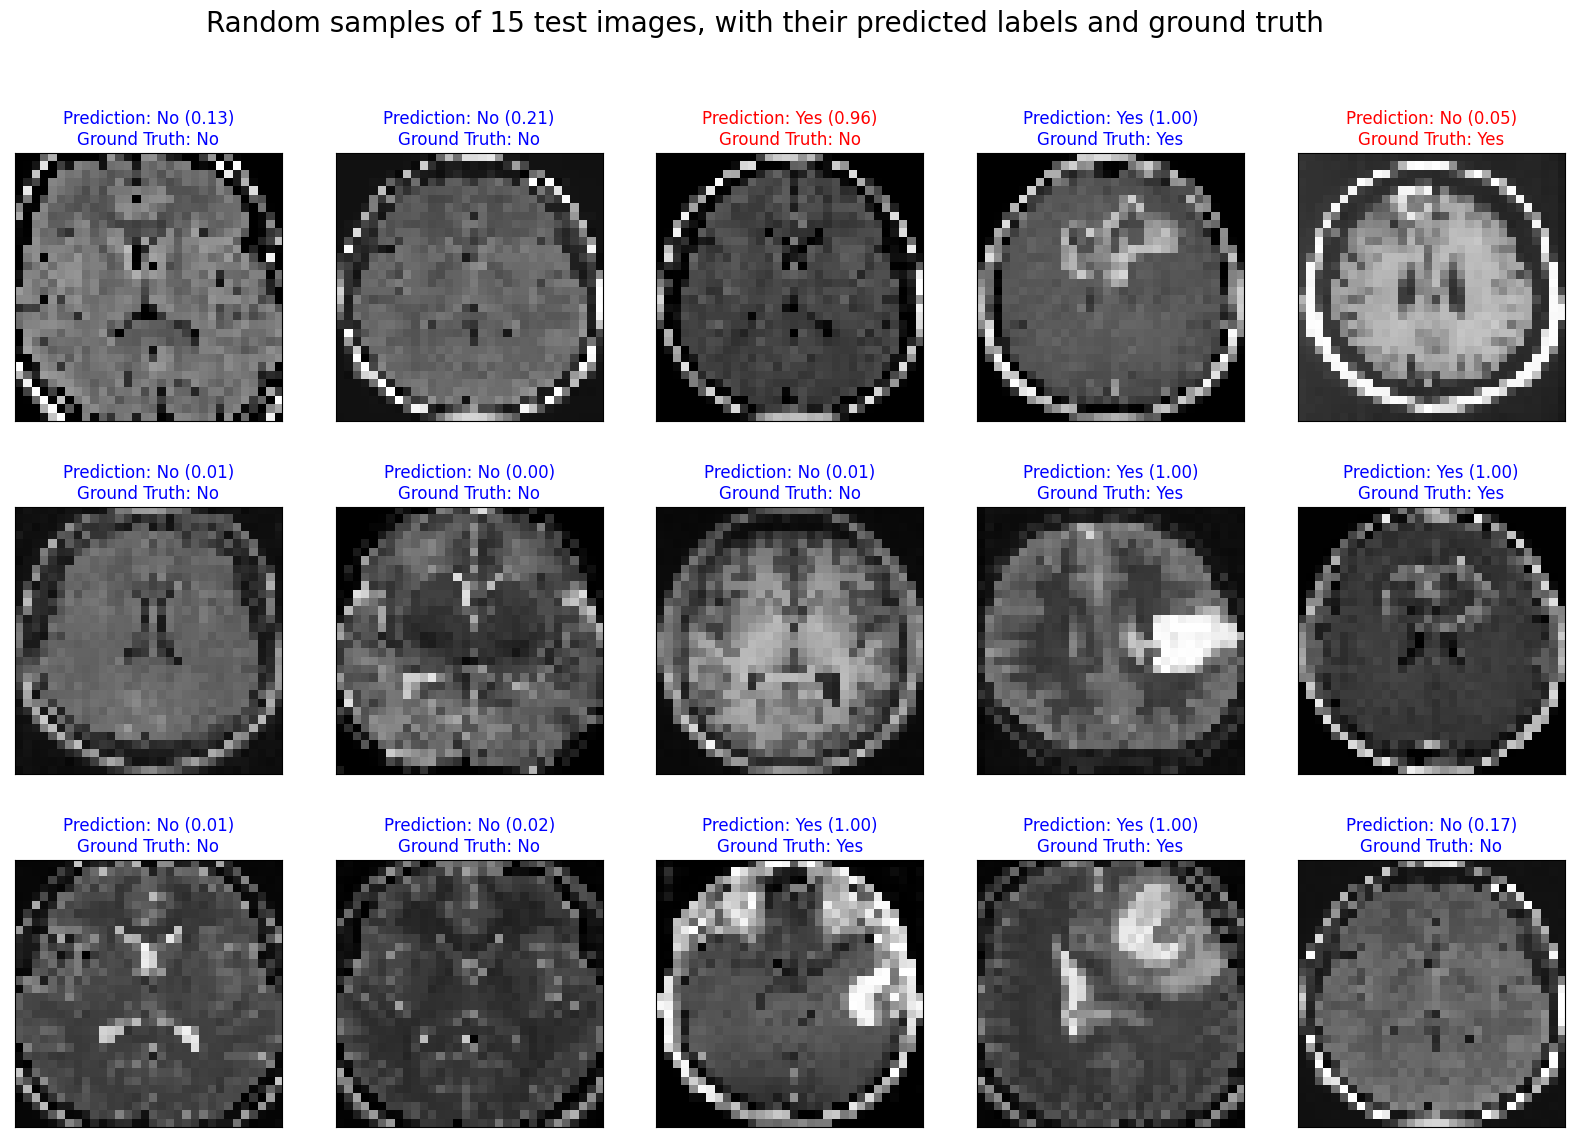

NameError: name 'x_orig_valid' is not defined

<Figure size 2000x800 with 0 Axes>

In [23]:
labels = ["No", "Yes"]
y_hat = model.predict(x_valid)
no_of_indices = 15
random_indices = np.random.choice(
    x_valid.shape[0], size=no_of_indices, replace=False)
# Plot a random sample of 15 test images, with their predicted labels and ground truth
figure = plt.figure(figsize=(20, 13))
sub_title = "Random samples of 15 test images, with their predicted labels and ground truth"
figure.suptitle(sub_title, fontsize=20)
for i in range(no_of_indices):
    rand_index = random_indices[i]

    # Display each image
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_valid[rand_index]))

    # Set the title for each image
    prediction_val = y_hat[rand_index][0]
    predict_index = 0 if (prediction_val < 0.5) else 1
    true_index = y_valid[rand_index]
    prediction = labels[predict_index]
    truth = labels[true_index]
    title_color = "blue" if predict_index == true_index else "red"
    ax_title = "Prediction: {} ({:.2f})\nGround Truth: {}".format(
        prediction, prediction_val, truth)
    ax.set_title(ax_title, color=title_color)
plt.show()

# Show the Original MRIs of the randomly selected images
figure = plt.figure(figsize=(20, 8))
figure.suptitle("Original MRIs of those randomly selected images", fontsize=20)
for i in range(no_of_indices):
    # get the original image
    img = x_orig_valid[random_indices[i]]
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(img))
plt.show()